In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn_som.som import SOM
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

Чтение тренировочного и тестового датасетов

In [3]:
train = pd.read_csv('data/train.csv', index_col=0)
test  = pd.read_csv('data/test_public.csv', index_col=0)

Оставить в train только такие же колонки, что и в test

In [3]:
train_cols = set([x for x in list(train.columns) if x.find('col') != -1])
test_cols = set([x for x in list(test.columns) if x.find('col') != -1])

In [4]:
train = train.drop(labels=list(train_cols - test_cols), axis=1)

Процент нулевых значений в атрибутах

In [5]:
n = len(train)
zero_cols = []
for col in train.columns:
    if col.find('col') != -1:
        zeros = int(len(train[train[col]==0]) / n * 100)
        if zeros > 80:
            zero_cols.append(col)
            print(col, zeros, '%')

col_n00 82 %
col_n01 99 %
col_n09 99 %
col_n10 100 %
col_n12 84 %
col_n15 94 %
col_n24 100 %
col_n27 95 %
col_n36 100 %
col_n42 100 %
col_n43 99 %
col_n47 93 %
col_n49 99 %
col_n56 100 %
col_n64 94 %


Удаление столбцов, где нулевых значений более 80%

In [6]:
train = train.drop(labels=zero_cols, axis=1)

Анализ корреляции (определение зависимых переменных)

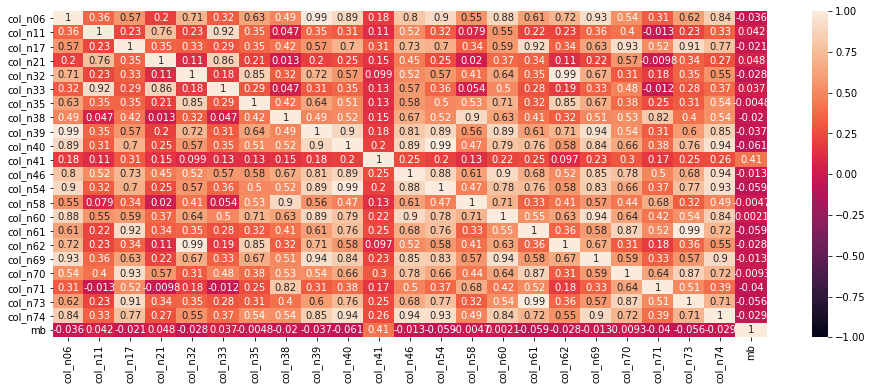

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

x_train_cols = [x for x in list(train.columns) if x.find('col') != -1]
x_train_cols.append('mb')

heatmap = plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train[x_train_cols].corr(), vmin=-1, vmax=1, annot=True)

Удаление взаимно-зависимых переменных

In [8]:
x_cols = [x for x in list(train.columns) if x.find('col') != -1]
x_cols.remove('col_n39')
x_cols.remove('col_n33')
x_cols.remove('col_n62')
x_cols.remove('col_n58')
x_cols.remove('col_n70')
x_cols.remove('col_n69')
x_cols.remove('col_n74')
x_cols.remove('col_n54')
x_cols.remove('col_n61')
x_cols.remove('col_n73')
corr = train[x_cols].corr()
indep_cols = []
for i, row in corr.iteritems():
    print(i, ': ', end='')
    d = False
    for col in x_cols:
        if row[col] >= 0.9 and i != col:
            d = True
            print(col, end=', ')
        if ~d:
            indep_cols.append(i)
        print()

print(indep_cols)

indep_cols = ['col_n06', 'col_n11', 'col_n17', 'col_n21', 'col_n32', 'col_n35', 'col_n38', 'col_n40', 'col_n41', 'col_n46', 'col_n60', 'col_n71']

col_n06 : 











col_n11 : 











col_n17 : 











col_n21 : 











col_n32 : 











col_n35 : 











col_n38 : 











col_n40 : 











col_n41 : 











col_n46 : 











col_n60 : 











col_n71 : 











['col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n06', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n11', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n17', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n21', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n32', 'col_n35', 'col_n35', 'col_n35', 'col_n35', 'col_n35', 'col_n35', 'col_n35'

In [9]:
train_cols = set([x for x in list(train.columns) if x.find('col')!=-1])
test_cols = set([x for x in list(test.columns) if x.find('col')!=-1])
train = train.drop(labels=list(train_cols - set(indep_cols)), axis=1)
test = test.drop(labels=list(test_cols - set(indep_cols)), axis=1)

In [10]:
all_data = pd.concat([train, test])

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121940 entries, 0 to 1121939
Data columns (total 16 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   time_idx  1121940 non-null  int64  
 1   mb        860750 non-null   float64
 2   place_id  1121940 non-null  int64  
 3   id2       1121940 non-null  int64  
 4   col_n06   1121940 non-null  float64
 5   col_n11   1121940 non-null  float64
 6   col_n17   1121940 non-null  float64
 7   col_n21   1121940 non-null  float64
 8   col_n32   1121940 non-null  float64
 9   col_n35   1121940 non-null  float64
 10  col_n38   1121940 non-null  float64
 11  col_n40   1121940 non-null  float64
 12  col_n41   1121940 non-null  float64
 13  col_n46   1121940 non-null  float64
 14  col_n60   1121940 non-null  float64
 15  col_n71   1121940 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 145.5 MB


### Выделение кластеров на всех данных (train+test)
Так как в test есть станции, которых нет в train, для них будем строить модель по кластеру

In [12]:
not_clustering_cols = ['mb', 'time_idx', 'id2', 'place_id']
data_mm = pd.DataFrame(MinMaxScaler().fit_transform(all_data.drop(columns=not_clustering_cols, axis=1)))

In [13]:
%%time
np.random.seed(42)
som = SOM(m=10, n=10, dim=len(data_mm.columns), max_iter=1000)
som_labels = som.fit_predict(np.array(data_mm), epochs=20, shuffle=False)

CPU times: user 4min 24s, sys: 1.48 s, total: 4min 26s
Wall time: 4min 33s


In [14]:
data_mm["label"] = som_labels
all_data['label'] = som_labels

In [15]:
print('Clusters count:', len(all_data['label'].unique()))

Clusters count: 47


In [16]:
train = all_data[~all_data['mb'].isna()]
test = all_data[all_data['mb'].isna()]

### Построение моделей
#### Построение моделей по кластеру и частоте

In [17]:
train_clusters = train.groupby(['label', 'id2', 'time_idx']).mean()
train_clusters.reset_index(inplace=True)
train_clusters = train_clusters.drop(labels=['place_id'], axis=1)
train_clusters.head()

,label,id2,time_idx,mb,col_n06,col_n11,col_n17,col_n21,col_n32,col_n35,col_n38,col_n40,col_n41,col_n46,col_n60,col_n71
0,6,0,0,0.618232,0.054668,0.000937,2.487548,0.050139,0.000719,0.000000,0.000460,0.557978,1.036902,0.275412,0.047797,0.000460
1,6,0,1,0.627723,0.052510,0.000937,2.486380,0.052951,0.000719,0.000000,0.000460,0.555342,1.017477,0.275906,0.047962,0.000460
2,6,0,2,0.527710,0.050032,0.001128,2.397302,0.048136,0.000577,0.000000,0.000369,0.509331,1.078620,0.262962,0.045370,0.003695
3,6,0,3,0.514171,0.050010,0.002006,2.487353,0.051877,0.000440,0.000202,0.000845,0.488265,1.226577,0.259791,0.046071,0.008166
4,6,0,4,0.626908,0.048714,0.002260,2.706619,0.052827,0.000578,0.000199,0.000833,0.464213,1.299866,0.265402,0.048192,0.005551


In [18]:
cluster_param_cols = ['label', 'id2', 'time_idx']
cluster_model_cols = ['mb'] + cluster_param_cols

print('Cluster model cols:', cluster_model_cols)

clusters = train_clusters['label'].unique()
frequencies = train_clusters['id2'].unique()

cluster_models = {}
for cluster in clusters:
    cluster_models[cluster] = {}    
    for frequency in frequencies:         
        df = pd.DataFrame(train_clusters, columns=cluster_model_cols)
        df = df[df['label'] == cluster]
        df = df[df['id2'] == frequency]
        y = df['mb']
        x = df.drop(labels=['mb'], axis=1)
        if ((len(x) > 0) and (len(y) > 0)):            
            model = DecisionTreeRegressor(random_state=0).fit(x, y)                                      
            cluster_models[cluster][frequency] = model.fit(x, y)
        del df

Cluster model cols: ['mb', 'label', 'id2', 'time_idx']


#### Построение моделей по станции и частоте

In [19]:
station_param_cols = [x for x in list(test.columns) if x.find('col')!=-1]
station_param_cols = ['time_idx'] + station_param_cols
station_model_cols = ['mb', 'place_id', 'id2'] + station_param_cols
print('Station model cols:', station_model_cols)

stations = train['place_id'].unique()
frequencies = train['id2'].unique()
print('Stattions count: ', len(stations))
i = 0
station_models = {}
for station in tqdm(stations):
    i += 1
    station_models[station] = {}    
    for frequency in frequencies:         
        df = pd.DataFrame(train, columns=station_model_cols)
        df = df[df['place_id'] == station]
        df = df[df['id2'] == frequency]
        y = df['mb']
        x = df.drop(labels=['mb', 'place_id', 'id2'], axis=1)
        if ((len(x) > 0) and (len(y) > 0)):
            model = DecisionTreeRegressor(random_state=0).fit(x, y)
            station_models[station][frequency] = model.fit(x, y)
        del df

  0%|          | 1/12458 [00:00<33:19,  6.23it/s]

Station model cols: ['mb', 'place_id', 'id2', 'time_idx', 'col_n06', 'col_n11', 'col_n17', 'col_n21', 'col_n32', 'col_n35', 'col_n38', 'col_n40', 'col_n41', 'col_n46', 'col_n60', 'col_n71']
Stattions count:  12458


100%|██████████| 12458/12458 [31:27<00:00,  6.60it/s]


### Расчет предсказания на тестовых данных

In [20]:
def calculate_model(x, pred_col):
    if x.place_id in station_models.keys() and x.id2 in station_models[x.place_id].keys():
        model = station_models[x.place_id][x.id2]
        X = np.array(x[station_param_cols]).reshape(1, -1)
        x[pred_col] = model.predict(X)[0]
    elif x.label in cluster_models.keys() and x.id2 in cluster_models[x.label].keys():
        model = cluster_models[x.label][x.id2]
        X = np.array(x[cluster_param_cols]).reshape(1, -1)
        x[pred_col] = model.predict(X)[0]
    else:
        print('No cluster model for label/id2: ', x.label, '/', x.id2)
    return x

test = test.apply(calculate_model, pred_col='mb', axis=1, result_type="expand")

Сохранение предсказания

In [21]:
test = test[['time_idx', 'place_id', 'id2', 'mb']]
test = test.astype({'time_idx': np.int8, 'place_id': np.int16, 'id2': np.int8})
# Обнуление отрицательных предсказаний
test[test['mb'] < 0] = 0
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261190 entries, 34 to 1121939
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   time_idx  261190 non-null  int8   
 1   place_id  261190 non-null  int16  
 2   id2       261190 non-null  int8   
 3   mb        261190 non-null  float64
dtypes: float64(1), int16(1), int8(2)
memory usage: 5.0 MB


In [24]:
test

,time_idx,place_id,id2,mb
34,42,0,5,2.769272
35,43,0,5,2.769272
36,44,0,5,2.769272
37,45,0,5,2.769272
38,46,0,5,2.769272
...,...,...,...,...
1121935,51,14604,5,0.582754
1121936,52,14604,5,0.582754
1121937,52,14604,2,0.618992
1121938,53,14604,5,0.582754


In [25]:
test.to_csv('submission.csv', index=False)